# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.utils import simple_preprocess
from gensim import downloader

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import SimpleRNN, GRU, Dense, Input, Embedding, TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Importing the dataset

In [2]:
data = pd.read_csv('/content/tweet_emotions.csv',usecols=['content', 'sentiment'])
#The twitter id column is dropped while loading the data

In [3]:
data.head()
#data has 2 columns - sentiment and content

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


# Data Preprocessing

In [4]:
data.info()
#data contains no null values
#both the features are categorical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  40000 non-null  object
 1   content    40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [5]:
data.shape

(40000, 2)

## preprocessing the content column suitable for nlp tasks

In [6]:
data['content'] = [simple_preprocess(doc) for doc in data['content']]

In [7]:
data.head()
#so the text data has been cleaned to a list of words

,sentiment,content
0,empty,"[tiffanylue, know, was, listenin, to, bad, hab..."
1,sadness,"[layin, bed, with, headache, ughhhh, waitin, o..."
2,sadness,"[funeral, ceremony, gloomy, friday]"
3,enthusiasm,"[wants, to, hang, out, with, friends, soon]"
4,neutral,"[dannycastillo, we, want, to, trade, with, som..."


# Data Splitting

In [11]:
x = data['content']
y = data['sentiment']

In [12]:
x.head()

,content
0,"[tiffanylue, know, was, listenin, to, bad, hab..."
1,"[layin, bed, with, headache, ughhhh, waitin, o..."
2,"[funeral, ceremony, gloomy, friday]"
3,"[wants, to, hang, out, with, friends, soon]"
4,"[dannycastillo, we, want, to, trade, with, som..."


In [13]:
y.head()

,sentiment
0,empty
1,sadness
2,sadness
3,enthusiasm
4,neutral


# Feature Extraction

So 2 x,y data are created -

x_simple has a single 25 dim vector representing a sentence
y_simple has label encoded values of 13 emotions

x_deep has 3dimension - each sentence is converted to a 2d matrix (for deep learning models)
y_deep has one hot encoded values of 13 emotions

## sentiment

In [14]:
y.value_counts()
#so there are 13 emotions

,count
sentiment,
neutral,8638
worry,8459
happiness,5209
sadness,5165
love,3842
surprise,2187
fun,1776
relief,1526
hate,1323


In [15]:
# one hot encoding the sentiment column
y_deep = pd.get_dummies(y,dtype = 'int')

In [16]:
y_deep.head()

,anger,boredom,empty,enthusiasm,fun,happiness,hate,love,neutral,relief,sadness,surprise,worry
0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0


In [17]:
encoder = LabelEncoder()
y_simple = encoder.fit_transform(y)
y_simple = pd.Series(y_simple, name='sentiment')


In [18]:
y_simple

,sentiment
0,2
1,10
2,10
3,3
4,8
...,...
39995,8
39996,7
39997,7
39998,5


## Content

In [19]:
# loading a glove twitter model for converting text to vectors
vectorize_model = downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [20]:
vectorize_model['happy']  #Checking the word vector for a random word

array([-1.2304 ,  0.48312,  0.14102, -0.0295 , -0.65253, -0.18554,
        2.1033 ,  1.7516 , -1.3001 , -0.32113, -0.84774,  0.41995,
       -3.8823 ,  0.19638, -0.72865, -0.85273,  0.23174, -1.0763 ,
       -0.83023,  0.10815, -0.51015,  0.27691, -1.1895 ,  0.98094,
       -0.13955], dtype=float32)

In [21]:
len(vectorize_model.index_to_key)  #this is the entire vocabulary of the model

1193514

In [22]:
#Now creating word vectors for each word in each doc in the corpus
x_list = [[vectorize_model[word] for word in doc if word in vectorize_model.index_to_key] for doc in x] #this will create a 3d list
#dimension 0 - for number of docs
#dimension 1 - for number of words in each
#dimension 2 - for number of features representing a word , here it is 25


In [23]:
len(x_list)

40000

In [24]:
len(x_list[0])

13

In [25]:
len(x_list[0][0])

25

In [26]:
np.average(x_list[0],axis = 0).shape

(25,)

In [27]:
#Removing the empty word vectors from the x and corrponding index from y
for i,doc in enumerate(x_list):
  if doc == []:
    x_list.remove(doc)
    y_simple.drop(i, axis = 0, inplace = True)
    y_deep.drop(i, axis = 0, inplace = True)

In [28]:
# Now creating 2 x data - for simple models and the other for deep learning models

x_simple = [np.average(doc, axis = 0)  for doc in x_list]
x_simple = np.array(x_simple)
#Taking avg of the vectors representing a single tweet to a single word vector

In [29]:
x_simple.shape

(39874, 25)

In [30]:
y_simple.shape

(39874,)

In [31]:
x_deep = pad_sequences(x_list, padding='post', dtype='float32')  #the sequences are padded as each sentence have a variable length of words

# Model Building and Evaluation

# Simple Models

### Train Test split

In [32]:
x_simple_train, x_simple_test, y_simple_train,y_simple_test = train_test_split(x_simple,y_simple,test_size = 0.2,random_state = 42)

### Random Forest

In [33]:
forest = RandomForestClassifier()
forest.fit(x_simple_train,y_simple_train)

RandomForestClassifier()

#### Evaluating the Model

In [34]:
y_pred_simple = forest.predict(x_simple_test)

In [35]:
print(accuracy_score(y_simple_test,y_pred_simple))  #Accuracy 0.27

0.28300940438871475


In [36]:
print(classification_report(y_simple_test,y_pred_simple))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00        37
           2       0.00      0.00      0.00       151
           3       0.00      0.00      0.00       158
           4       0.10      0.00      0.01       351
           5       0.25      0.23      0.24      1023
           6       0.50      0.01      0.03       269
           7       0.36      0.22      0.27       761
           8       0.28      0.49      0.36      1703
           9       0.00      0.00      0.00       299
          10       0.24      0.09      0.13      1041
          11       0.08      0.00      0.00       446
          12       0.29      0.53      0.38      1718

    accuracy                           0.28      7975
   macro avg       0.16      0.12      0.11      7975
weighted avg       0.25      0.28      0.23      7975



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Deep learning Models

### Train Test split

In [37]:
x_deep_train, x_deep_test, y_deep_train,y_deep_test = train_test_split(x_deep,y_deep,test_size = 0.2,random_state = 42)

### ANN

here we use the simple x data with the onehot encoded values of y

In [38]:
model = Sequential()
# model.add(Input(shape = (25,)))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(13,activation = 'softmax'))

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy','precision'])

In [39]:
history = model.fit(x_simple_train,y_deep_train,
                            epochs = 20,
                            validation_data = (x_simple_test,y_deep_test))

Epoch 1/20
997/997 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2277 - loss: 2.2069 - precision: 0.3235 - val_accuracy: 0.2676 - val_loss: 2.0618 - val_precision: 0.3750
Epoch 2/20
997/997 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2645 - loss: 2.0703 - precision: 0.4644 - val_accuracy: 0.2760 - val_loss: 2.0533 - val_precision: 0.4688
Epoch 3/20
997/997 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2716 - loss: 2.0552 - precision: 0.4894 - val_accuracy: 0.2737 - val_loss: 2.0461 - val_precision: 0.4211
Epoch 4/20
997/997 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2655 - loss: 2.0634 - precision: 0.4810 - val_accuracy: 0.2781 - val_loss: 2.0416 - val_precision: 0.4274
Epoch 5/20
997/997 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2668 - loss: 2.0615 - precision: 0.4438 - val_accuracy: 0.2811 - val_loss: 2.0410 - val_precision: 0.4433
Epoch 6/20
997/997 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2709 - loss: 2.0452 - precision: 0.5070 - val_accuracy: 0.2746 - val_loss:

#### Evaluation

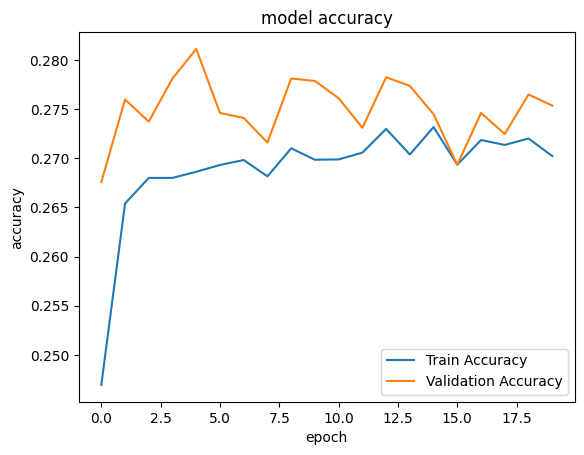

In [40]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

In [41]:
y_deep_pred = model.predict(x_simple_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [46]:
pred_classes = np.argmax(y_deep_pred,axis = 1)
actual_classes = np.argmax(y_deep_test,axis = 1)
print(accuracy_score(pred_classes,actual_classes))

0.2753605015673981


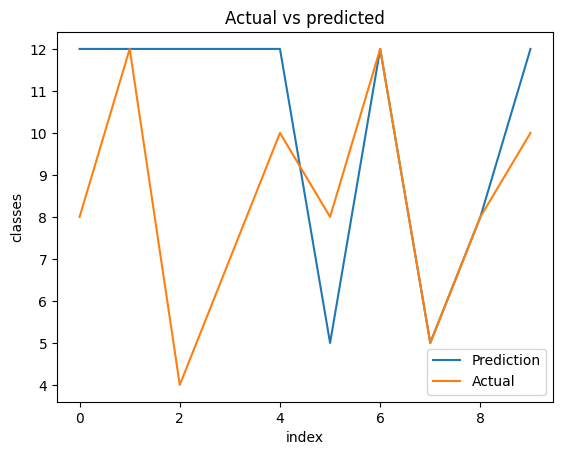

In [94]:
plt.plot(pred_classes[0:10], label = 'Prediction')
plt.plot(actual_classes[0:10], label = 'Actual')
plt.title('Actual vs predicted')
plt.ylabel('classes')
plt.xlabel('index')
plt.legend()

### GRU

here the x_deep and y_deep are used

In [92]:
gru_model = Sequential()
gru_model.add(Input(shape = (None,25)))
gru_model.add(GRU(128,return_sequences = True))
gru_model.add(GRU(32,return_sequences = True))
gru_model.add(GRU(16,return_sequences = False))
gru_model.add(Dense(64,activation = 'relu'))
gru_model.add(Dense(13,activation = 'softmax'))

gru_model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy','precision'])

In [93]:
history_gru = gru_model.fit(x_deep_train,y_deep_train,
                            epochs = 15,
                            validation_data = (x_deep_test,y_deep_test))

Epoch 1/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.2243 - loss: 2.1648 - precision: 0.1515 - val_accuracy: 0.2944 - val_loss: 2.0340 - val_precision: 0.0000e+00
Epoch 2/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.2921 - loss: 2.0260 - precision: 0.3806 - val_accuracy: 0.3095 - val_loss: 1.9910 - val_precision: 0.6809
Epoch 3/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.3123 - loss: 1.9786 - precision: 0.5028 - val_accuracy: 0.3190 - val_loss: 1.9778 - val_precision: 0.7174
Epoch 4/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.3184 - loss: 1.9630 - precision: 0.5341 - val_accuracy: 0.3236 - val_loss: 1.9658 - val_precision: 0.5087
Epoch 5/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.3347 - loss: 1.9334 - precision: 0.5375 - val_accuracy: 0.3284 - val_loss: 1.9603 - val_precision: 0.5721
Epoch 6/15
997/997 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.3369 - loss: 1.9181 - precision: 0.5267 - val_accuracy: 0.

In [96]:
y_deep_pred = gru_model.predict(x_deep_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [97]:
pred_classes = np.argmax(y_deep_pred,axis = 1)
actual_classes = np.argmax(y_deep_test,axis = 1)
print(accuracy_score(pred_classes,actual_classes))

0.2921630094043887


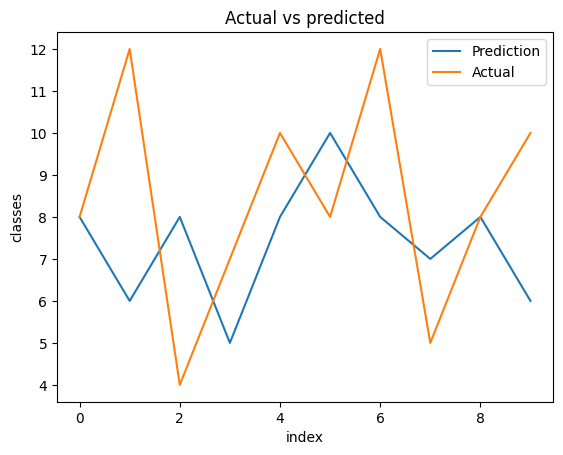

In [98]:
plt.plot(pred_classes[0:10], label = 'Prediction')
plt.plot(actual_classes[0:10], label = 'Actual')
plt.title('Actual vs predicted')
plt.ylabel('classes')
plt.xlabel('index')
plt.legend()